# Scrabble Player Rating

https://www.kaggle.com/competitions/scrabble-player-rating/

- Aim to finish before 2/18
- Todo: create a baseline (LST?) model

Variables to add into modeling input
- player's previous rating
- rating of players in the previous n games 
- player's board in the turns.csv


## Dataset Description

The dataset includes information about ~73,000 Scrabble games played by three bots on Woogles.io: BetterBot (beginner), STEEBot (intermediate), and HastyBot (advanced). The games are between the bots and their opponents who are regular registered users. You are using metadata about the games as well as turns in each game (i.e., players' racks and where and what they played, AKA gameplay) to predict the rating of the human opponents in the test set (test.csv). You will train your model on gameplay data from one set of human opponents to make predictions about a different set of human opponents in the test set.

There is metadata for each game (games.csv), gameplay data about turns played by each player in each game (turns.csv), and final scores and ratings from BEFORE a given game was played for each player in each game (train.csv and test.csv).

Here is an example of a game played on woogles.io: https://woogles.io/game/icNJtmxy. Use the "Examine" button to replay the game turn-by-turn.

### Files
- `games.csv` - metadata about games (e.g., who went first, time controls)
- `turns.csv` - all turns from start to finish of each game
- `train.csv` - final scores and ratings for each player in each game; ratings for each player are as of BEFORE the game - was played
- `test.csv` - final scores and ratings for each player in each game; ratings for each player are as of BEFORE the game was played
- `sample_submission.csv` - a sample submission file in the correct format

### turns.csv
`turns.csv` contains full data for every turn for each game.

- **game_id** Unique id for the game
- **turn_number** The turn number in the game
- **nickname** Player's username on woogles.io
- **rack** Player's current rack
- **location** Where the player places their turn on the board (NA for games in the test set or if the player didn't make a play, e.g., if they exchanged)
- **move** Tiles the player laid (NA for games in the test set; "--" if the turn_type was "Pass"; "(challenge)" if the turn_type was "Challenge"; "-" plus tiles exchanged if the turn_type was "Exchange"; at the end of the game, remaining tiles in a player's rack are in parentheses)
- **points** Points the player earned (or lost) in their turn
- **score** Player's total score at the time of the turn
- **turn_type** Type of turn played ("Play", "Exchange", "Pass", "Six-Zero Rule" (i.e., a game that ends when players pass 3 turns in a row each), "Challenge")

### games.csv

- **game_id** Unique id for the game
- **first** Which player went first
- **time_control_name** Name of time control used ("regular", "rapid", or "blitz")
- **game_end_reason** How the game ended
- **winner** Who won the game
- **created_at** When the game was created
- **lexicon** English lexicon used in the game ("CSW19", "NWL20", "CSW21")
- **initial_time_seconds** Time limit each player has in the game (defines the time control name)
- **increment_seconds** Time increment each player gets each time they play a turn
- **rating_mode** Whether the game counts towards player ratings or not ("RATED", "CASUAL")
- **max_overtime_minutes** How far past the initial time limit players can go before they timeout
- **game_duration_seconds** How long the game lasted

### test.csv and train.csv
There's score and rating data about 1031 players in `train.csv` and 443 players in `test.csv`. Except for the three bots, no players are in both `train.csv` and `test.csv`. Ratings for the players are from BEFORE the game was played. Your task is to predict what the rating of the human player was in `test.csv` BEFORE the given game was played.

- **game_id** Unique id for the game
- **nickname** Player's username on woogles.io
- **score** Final score for each player for each game.
- **rating** Player's rating on woogles.io BEFORE the game was played; ratings are per Lexicon / time control name (AKA game variant). In test.csv, ratings are NA for player games; this is what you are predicting.

## EDA Findings

- test/train data is split by nicknames
- test nicknames do appear in both games and turns
- probably need to use time-series model (LSTM, RNN, Transformer?)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data/test.csv
data/turns.csv
data/games.csv
data/train.csv
data/sample_submission.csv


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sample_sub = pd.read_csv('data/sample_submission.csv')
games = pd.read_csv('data/games.csv')
turns = pd.read_csv('data/turns.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
# seperate humans and bots and merge dataframes
bot_names = ['BetterBot', 'STEEBot', 'HastyBot']
bots = train[train.nickname.isin(bot_names)].copy()
humans = train[~train.nickname.isin(bot_names)]

# rename bot columns 
bots.rename(columns={'nickname': 'bot', 'score': 'bot_score', 'rating': 'bot_rating'}, inplace=True)

train_merged = humans.merge(bots, on='game_id')
train_merged

,game_id,nickname,score,rating,bot,bot_score,bot_rating
0,1,stevy,429,1500,BetterBot,335,1637
1,3,davidavid,440,1811,BetterBot,318,2071
2,4,Inandoutworker,119,1473,BetterBot,478,1936
3,5,stevy,325,1500,STEEBot,427,1844
4,6,HivinD,378,2029,STEEBot,427,2143
...,...,...,...,...,...,...,...
50405,72767,HAYDEN,340,1395,BetterBot,414,1952
50406,72770,samsiah06,97,1332,HastyBot,590,2237
50407,72771,BB-8,390,1500,HastyBot,393,1614
50408,72772,Gtowngrad,388,1364,BetterBot,442,1674


# modeling

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


In [47]:
# prepare data
df = train_merged#[:1000]
one_hot = pd.get_dummies(df.bot)
df = df.drop(['bot', 'nickname', 'game_id'], axis=1)
df = df.join(one_hot)
df.head()

,score,rating,bot_score,bot_rating,BetterBot,HastyBot,STEEBot
0,429,1500,335,1637,1,0,0
1,440,1811,318,2071,1,0,0
2,119,1473,478,1936,1,0,0
3,325,1500,427,1844,0,0,1
4,378,2029,427,2143,0,0,1


In [48]:
# split into train/validation
X = df.drop(['rating'], axis=1).to_numpy()
y = df['rating'].to_numpy()

print('X and y shapes:', X.shape, y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train X and y shapes:', X_train.shape, y_train.shape)
print('Validation X and y shapes:', X_val.shape, y_val.shape)

X and y shapes: (50410, 6) (50410,)
Train X and y shapes: (40328, 6) (40328,)
Validation X and y shapes: (10082, 6) (10082,)


In [51]:
# create model
reg = LinearRegression().fit(X_train, y_train)
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_val)

print('Train Mean absoulte error: %.2f' % mean_absolute_error(y_train, train_pred))
print('Test Mean absolute error: %.2f' % mean_absolute_error(y_val, test_pred))

print('Train Mean squared error: %.2f' % mean_squared_error(y_train, train_pred))
print('Test Mean squared error: %.2f' % mean_squared_error(y_val, test_pred))

Train Mean absoulte error: 112.36
Test Mean absolute error: 113.43
Train Mean squared error: 22599.32
Test Mean squared error: 22835.63


# playground

(array([1.1000e+01, 1.0200e+02, 2.2740e+03, 1.2211e+04, 2.6102e+04,
        6.9980e+03, 1.7720e+03, 6.8700e+02, 2.0000e+02, 5.3000e+01]),
 array([-661. , -471.6, -282.2,  -92.8,   96.6,  286. ,  475.4,  664.8,
         854.2, 1043.6, 1233. ]),
 <BarContainer object of 10 artists>)

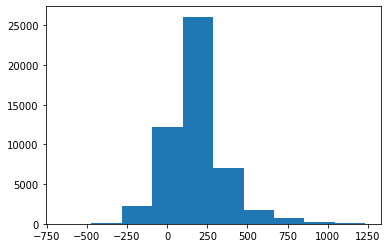

In [59]:
plt.scatter(np.array(train_merged.bot_rating), np.array(train_merged.rating))


In [62]:
filtered = train_merged[train_merged.nickname == 'HivinD']
# plt.figure(figsize=(20, 10))
# plt.plot(range(592), filtered.rating)

filtered.merge(games, on='game_id').head(10)

,game_id,nickname,score,rating,bot,bot_score,bot_rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,6,HivinD,378,2029,STEEBot,427,2143,HivinD,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541
1,19,HivinD,380,2151,STEEBot,471,2259,HivinD,regular,STANDARD,0,2022-09-20 09:09:39,CSW21,900,0,RATED,1,278.572545
2,26,HivinD,372,2086,STEEBot,427,2096,HivinD,regular,STANDARD,0,2022-08-11 08:22:48,CSW21,900,0,RATED,1,712.019593
3,210,HivinD,369,2072,STEEBot,446,2102,HivinD,regular,STANDARD,0,2022-09-17 11:46:04,CSW21,900,0,RATED,1,383.269923
4,666,HivinD,421,2016,BetterBot,319,1926,HivinD,regular,STANDARD,1,2022-08-21 15:11:09,CSW21,900,0,RATED,1,360.889033
5,1084,HivinD,500,2095,STEEBot,372,2169,HivinD,regular,STANDARD,1,2022-09-10 04:31:01,CSW21,900,0,RATED,1,253.895098
6,1321,HivinD,410,2131,STEEBot,478,2188,STEEBot,regular,STANDARD,0,2022-09-01 18:46:31,CSW21,900,0,RATED,1,440.277582
7,1410,HivinD,415,2139,STEEBot,446,2103,HivinD,regular,STANDARD,0,2022-08-25 16:38:02,CSW21,900,0,RATED,1,364.528859
8,1518,HivinD,475,2009,STEEBot,475,2152,STEEBot,regular,STANDARD,-1,2022-08-13 05:32:30,CSW21,900,0,RATED,1,182.705356
9,1552,HivinD,276,2048,STEEBot,618,2182,STEEBot,regular,STANDARD,0,2022-09-21 16:23:38,CSW21,900,0,RATED,1,144.095946


# combine games on mini_train

In [31]:
mini_train_merged = train_merged[:10]
mini_train_merged = mini_train_merged.merge(games, on='game_id')

# drop useless columns
drop_columns = ['initial_time_seconds', 'increment_seconds', 'max_overtime_minutes', 'game_duration_seconds', 
                'created_at', 'lexicon', 'game_end_reason']
mini_train_merged.drop(drop_columns, axis=1, inplace=True)

mini_train_merged.head()

,game_id,nickname,score,rating,bot,bot_score,bot_rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,stevy,429,1500,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,3,davidavid,440,1811,BetterBot,318,2071,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
2,4,Inandoutworker,119,1473,BetterBot,478,1936,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
3,5,stevy,325,1500,STEEBot,427,1844,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722
4,6,HivinD,378,2029,STEEBot,427,2143,HivinD,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541
5,8,AliSalman1,414,2067,HastyBot,528,2244,HastyBot,regular,STANDARD,0,2022-09-06 21:03:24,CSW21,900,0,RATED,1,458.019893
6,9,cccc,364,1641,BetterBot,464,1624,BetterBot,regular,STANDARD,0,2022-09-02 01:55:00,NWL20,1200,0,RATED,1,567.144135
7,10,squashy,299,1838,BetterBot,415,1972,squashy,regular,STANDARD,0,2022-08-07 05:03:03,CSW21,900,0,RATED,1,118.911215
8,12,BB-8,351,1500,HastyBot,408,1614,HastyBot,regular,STANDARD,0,2022-09-18 09:16:18,ECWL,900,0,CASUAL,10,253.085243
9,13,Trayz,434,2017,STEEBot,381,2122,STEEBot,regular,STANDARD,1,2022-09-06 12:13:19,CSW21,1440,0,CASUAL,1,682.534650


In [37]:
games.game_end_reason.value_counts()

STANDARD              67987
RESIGNED               2346
TIME                   2202
CONSECUTIVE_ZEROES      238
Name: game_end_reason, dtype: int64

In `games.csv`, the values to the winner column are: 1 (if player wins) or 0 (if the bot wins)


`turns[turns.game_id == 1].tail()`

In [6]:
# winner = 1
# # turns[turns.game_id == 1].tail()
# winner = 0
# # turns[turns.game_id == 72772].tail()

In [16]:
turns.head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


In [17]:
sample_sub.head()

,game_id,rating
0,2,1790.322674
1,7,1790.322674
2,11,1790.322674
3,14,1790.322674
4,27,1790.322674


In [42]:
test.head()

,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0


In [38]:
test[test.nickname == 'Super']

,game_id,nickname,score,rating
0,2,Super,488,NaN
13,32,Super,420,NaN
377,544,Super,345,NaN
1883,3038,Super,379,NaN
2015,3268,Super,346,NaN
...,...,...,...,...
42564,69304,Super,281,NaN
43304,70602,Super,333,NaN
43827,71424,Super,433,NaN
44079,71791,Super,446,NaN


In [26]:
turns[turns.nickname == 'Super' && g]

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
27,2,1,Super,AFINRTV,8D,FAINT,24,24,Play
29,2,3,Super,AAERTVW,F10,WAVER,34,58,Play
31,2,5,Super,AABEFTY,15G,FY,44,102,Play
33,2,7,Super,AABCDET,K10,BEAD,33,135,Play
35,2,9,Super,ACEGIST,L6,CAGIEST,94,229,Play
...,...,...,...,...,...,...,...,...,...
1983800,71982,20,Super,?CEKORS,14I,dOCKERS,80,403,Play
1983802,71982,22,Super,BDLNNOP,11L,BOND,14,417,Play
1983804,71982,24,Super,ILNNOP,15A,NIL,25,442,Play
1983806,71982,26,Super,NOP,B7,P.ON,8,450,Play


Objective: predict rating based off score, bot, and bot score.

- OHE bots
- create small NN
- MAE loss?

In [19]:
np.array(merged.bot)
merged.bot[:100]

array(['BetterBot', 'STEEBot', 'HastyBot'], dtype=object)

In [22]:
le = preprocessing.LabelEncoder()
le.fit(merged.bot[:100])
le.transform(merged.bot[:10])

# le.fit([1, 2, 2, 6])

array([0, 0, 0, 2, 2, 1, 0, 0, 1, 2])

In [25]:
np.array(merged.bot[:10])

array(['BetterBot', 'BetterBot', 'BetterBot', 'STEEBot', 'STEEBot',
       'HastyBot', 'BetterBot', 'BetterBot', 'HastyBot', 'STEEBot'],
      dtype=object)